In [544]:
import portfolioTheory as pt
import yftickers as ticks
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from scipy.stats import kurtosis
from scipy.stats import norm
from scipy.stats import probplot
import yfinance as yf
import statsmodels.api as sm
import pylab
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

# Data collection

In [499]:
ftse = yf.download('^FTSE', start=dt.datetime(2002,1,1), end=dt.datetime(2023,1,1))['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [501]:
ftseLogReturn = np.log(ftse/ftse.shift(1))

In [8]:
tickers = ticks.ftse100
start=dt.datetime(2000,1,1)
end=dt.datetime(2023,1,1)
threshold=0.9

In [9]:
portfolio = pt.Portfolio(tickers, start, end)
portfolio.getData()
portfolio.cleanData(dateRange=['2002','2023'], threshold=threshold)
portfolio.calculate_stats()

[*********************100%***********************]  101 of 101 completed

3 Failed downloads:
- MGGT.L: No timezone found, symbol may be delisted
- RMG.L: No timezone found, symbol may be delisted
- AUTO: No timezone found, symbol may be delisted
33 columns were removed because there were less observations than the threshold (0.9):
AAL       73.20%
ABDN.L    70.15%
AHT       82.06%
AUTO       0.00%
BME       75.34%
BRBY.L    87.60%
CCH.L     41.20%
CPG       81.42%
EDV       63.31%
ENT.L     76.87%
EXPN.L    69.06%
FLTR      49.55%
FRES.L    62.34%
GLEN.L    49.39%
HIK.L     73.07%
HL.L      66.55%
IAG       82.57%
IHG       83.66%
III       67.39%
INVR.L    61.61%
ITRK.L    88.18%
LAND      42.11%
MGGT.L     0.00%
MNDI.L    66.01%
NWG       64.48%
OCDO.L    52.96%
PHNX.L    55.82%
PRU       89.25%
RMG.L      0.00%
RMV.L     71.53%
SKG.L     67.24%
SMIN      46.18%
UTG       79.96%
dtype: object


In [30]:
portfolio.raw_data.to_csv('portfolio_data_all_raw.csv')

# EDA

In [10]:
print('{} years and {} average days'.format(len(portfolio.logReturns.groupby(portfolio.logReturns.index.year)),round(len(portfolio.logReturns)/len(portfolio.logReturns.groupby(portfolio.logReturns.index.year)),3)))

21 years and 236.952 average days


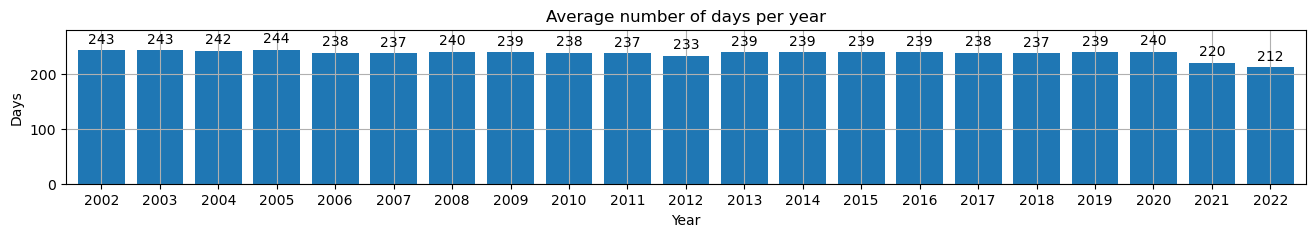

In [11]:
avDays = portfolio.logReturns.groupby(portfolio.logReturns.index.year).count().mean(axis=1)
fig = plt.figure(figsize=(16,2))
plt.bar(avDays.index,avDays.values)
plt.xticks(avDays.index)
plt.ylim(0,280)
plt.margins(x=0.01)
plt.grid()
plt.ylabel('Days')
plt.xlabel('Year')
plt.title('Average number of days per year')
for x,y in zip(avDays.index,avDays.values):

    label = "{}".format(int(y))

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')
plt.show()

In [12]:
fig = px.bar(avDays, x=avDays.index, y=avDays.values, width=800, height=300, text_auto=True, range_y=(0,300), title='Average number of days per year')
fig.update_traces(textfont_size=12, textposition="outside", cliponaxis=False)
fig.update_xaxes(tickmode='linear',tickangle= -90)
fig.update_layout(yaxis_title="Count of days")
fig.show()

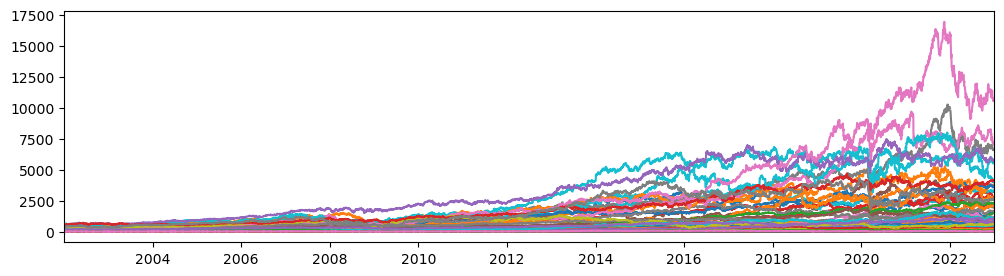

In [13]:
plt.figure(figsize=(12,3))
plt.plot(portfolio.raw_data['Adj Close'])
plt.margins(x=0)
plt.savefig('media/prices')
plt.show()

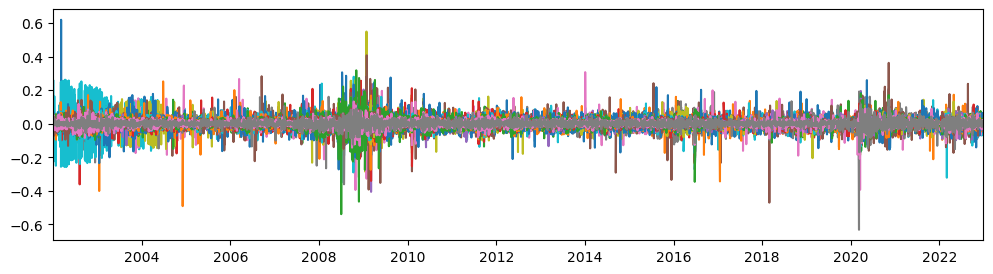

In [14]:
plt.figure(figsize=(12,3))
plt.plot(portfolio.logReturns)
plt.margins(x=0)
plt.savefig('media/Returns')
plt.show()

In [15]:
meanReturns = portfolio.logReturns.mean()
covMatrix = portfolio.covMatrix
portfolio.calculate_PortPerformance(pt.equallyWeighted(meanReturns,covMatrix)[1][1])

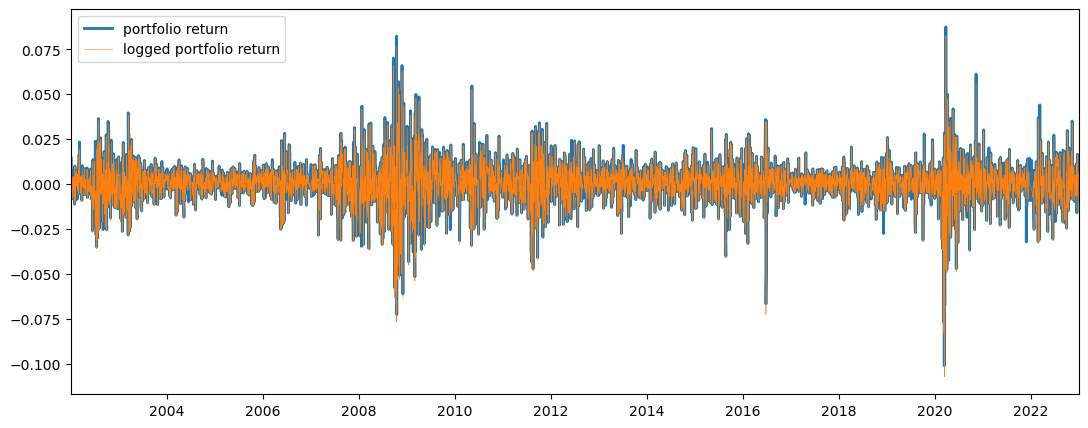

In [16]:
plt.figure(figsize=(13,5))
plt.plot(portfolio.portReturns, lw=2, label='portfolio return')
plt.plot(portfolio.portlogReturns, lw=0.4, label='logged portfolio return')
plt.legend()
plt.margins(x=0)
plt.savefig('media/portReturns')
plt.show()

In [17]:
import pandas as pd

In [18]:
df = pd.concat([portfolio.portReturns,portfolio.portlogReturns], axis=1)

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio.portReturns.index, y=portfolio.portReturns,
                    mode='lines',
                    name='Returns',
                        marker_size=1,
                        marker_line_width=0.001,
                        line_color='red')
             )
fig.add_trace(go.Scatter(x=portfolio.portlogReturns.index, y=portfolio.portlogReturns,
                    mode='lines',
                    name='Log returns',
                        marker_size=1,
                        marker_line_width=0.01,
                        line_color='blue',
                        opacity=0.7)
             )
fig.update_layout(
    title="Comparing returns with log returns",
    xaxis_title="Date",
    yaxis_title="Returns",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.show()

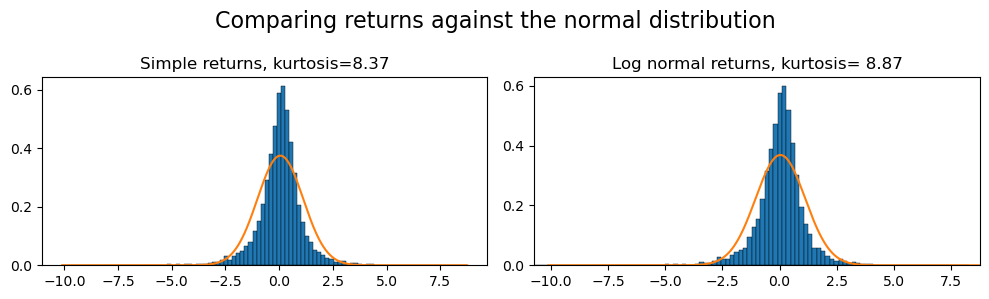

In [20]:
x = np.linspace(portfolio.portReturns.min(),portfolio.portReturns.max(),len(portfolio.portReturns))*100
mu0 = portfolio.portReturns.mean()*100
sigma0 = portfolio.portReturns.std()*100
mu1 = portfolio.portlogReturns.mean()*100
sigma1 = portfolio.portlogReturns.std()*100
fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].hist(portfolio.portReturns*100, bins =100, density=True,edgecolor='black',linewidth=0.3)
ax[0].plot(x, norm.pdf(x, loc=mu0, scale=sigma0))
ax[0].set_title('Simple returns, kurtosis={}'.format(round(kurtosis(portfolio.portReturns, bias=False),2)))
ax[1].hist(portfolio.portlogReturns*100, bins =100, density=True,edgecolor='black',linewidth=0.3)
ax[1].plot(x, norm.pdf(x, loc=mu1, scale=sigma1))
ax[1].set_title('Log normal returns, kurtosis= {}'.format(round(kurtosis(portfolio.portlogReturns, bias=False),2)))
plt.margins(x=0)
fig.suptitle('Comparing returns against the normal distribution', fontsize=16)
plt.tight_layout()
plt.savefig('media/Ndistribution')
plt.show()

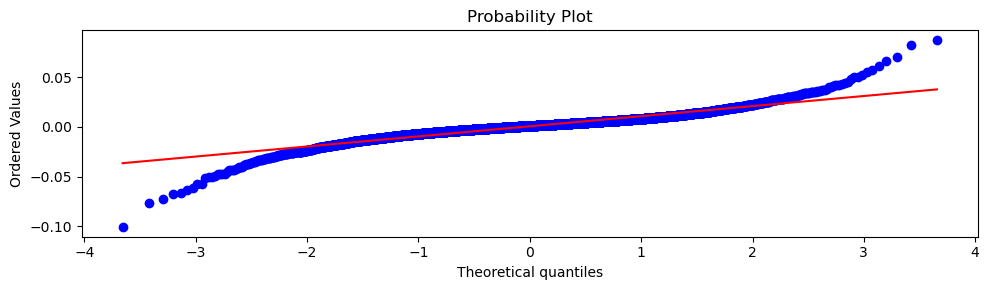

In [21]:
plt.figure(figsize=(10,3))
probplot(portfolio.portReturns, dist="norm", plot=pylab)
plt.tight_layout()
plt.savefig('media/QQ plot')
plt.show()

# Portfolio optimisation

## Initial set up

In [22]:
meanReturns = portfolio.logReturns.mean()
covMatrix = portfolio.covMatrix

In [23]:
maxSR0001 = pt.maxSharpeRatio(meanReturns,covMatrix,contraintSet=(0.0001, 1))
maxSR001 = pt.maxSharpeRatio(meanReturns,covMatrix,contraintSet=(0.001, 1))
maxSR01 = pt.maxSharpeRatio(meanReturns,covMatrix,contraintSet=(0.01, 1))
maxSR = pt.maxSharpeRatio(meanReturns,covMatrix)

C:\Users\johan.lai\Anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



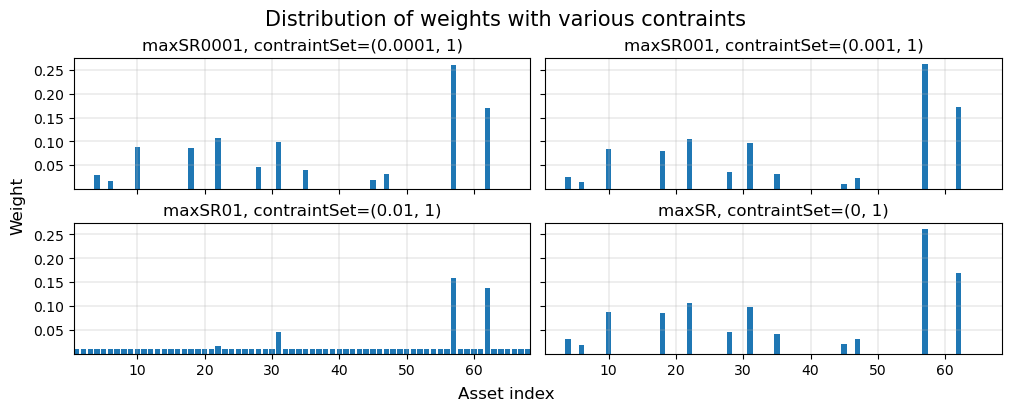

In [24]:
fig, axs = plt.subplots(2,2,figsize=(10,4), layout='constrained', sharey=True, sharex=True)
fig.suptitle('Distribution of weights with various contraints', fontsize=15)
fig.supylabel('Weight')
fig.supxlabel('Asset index')
axs[0][0].bar(np.arange(1,len(maxSR0001[1][1])+1),height=maxSR0001[1][1])
axs[0][0].set_title('maxSR0001, contraintSet=(0.0001, 1)')
axs[0][1].bar(np.arange(1,len(maxSR001[1][1])+1),height=maxSR001[1][1])
axs[0][1].set_title('maxSR001, contraintSet=(0.001, 1)')
axs[1][0].bar(np.arange(1,len(maxSR01[1][1])+1),height=maxSR01[1][1])
axs[1][0].set_title('maxSR01, contraintSet=(0.01, 1)')
axs[1][1].bar(np.arange(1,len(maxSR[1][1])+1),height=maxSR[1][1])
axs[1][1].set_title('maxSR, contraintSet=(0, 1)')
for i in axs.flatten():
    i.yaxis.set_ticks([0.05,0.1,0.15,0.2,0.25])
    i.grid(visible=True,which='both',linewidth=0.3)
    i.margins(x=0)
plt.savefig('media/ConstrainedWeightsDistribution')
plt.show()

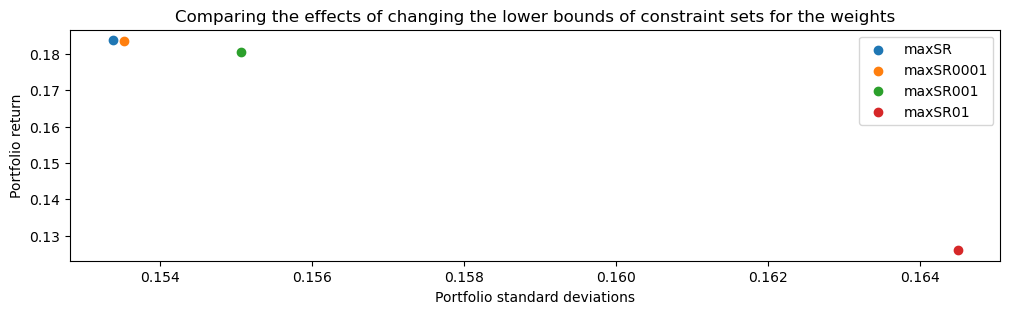

In [27]:
weights_dist_str = ['maxSR', 'maxSR0001', 'maxSR001', 'maxSR01']
weights_dist = [maxSR, maxSR0001, maxSR001, maxSR01]
weights_dist_performance = {}
for i,x in enumerate(weights_dist):
    weights_dist_performance[weights_dist_str[i]]=pt.portfolioPerformance(x[1][1], meanReturns,covMatrix)
df = pd.DataFrame(weights_dist_performance).T
df.rename(columns={0:'returns', 1:'std'}, inplace=True)
plt.figure(figsize=(12,3))
for i in weights_dist_str:
    plt.scatter(y=df.loc[i][0], x=df.loc[i][1], label=i)
plt.title('Comparing the effects of changing the lower bounds of constraint sets for the weights')
plt.ylabel('Portfolio return')
plt.xlabel('Portfolio standard deviations')
plt.legend()
plt.savefig('media/PerformanceOfContraintedWeights')
plt.show()

pt.EF_graph(portfolio.logReturns.mean(), portfolio.covMatrix)

# Adding a new line

In [35]:
meanReturns = portfolio.logReturns.mean()
covMatrix = portfolio.covMatrix
#meanReturns, covMatrix

# No reset

In [38]:
maxSharpe = pt.maxSharpeRatio(meanReturns, covMatrix)
noReset = portfolio.portlogReturns

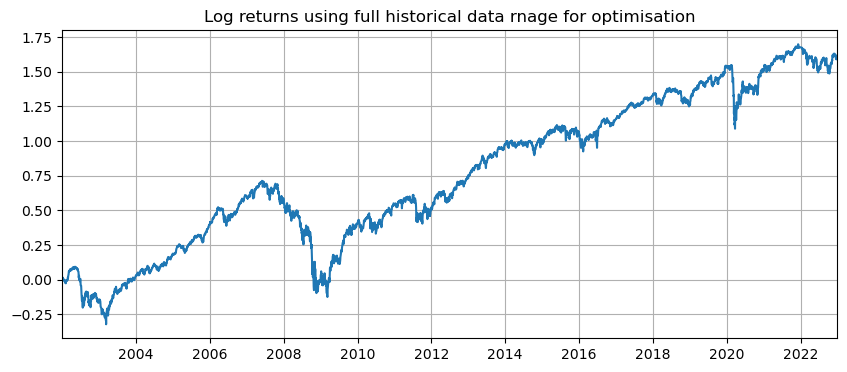

In [145]:
plt.figure(figsize=(10,4))
plt.title('Log returns using full historical data rnage for optimisation')
plt.margins(x=0)
plt.plot(np.cumsum(noReset))
plt.grid()
plt.show()

### Testing the reset intervals

##### In sample

In [580]:
# Annual
annualReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=0.0),index=portfolio.logReturns.index)
annualReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.groupby(portfolio.logReturns.index.year):
    meanReturns = x.mean()
    covMatrix = x.cov()
    annualReset['ret'][x.index] = portfolio.logReturns.loc[x.index] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T 
#Bannual
biAnnualReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=0.0),index=portfolio.logReturns.index)
biAnnualReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.resample('6M',label='right',closed='left'):
    meanReturns = x.mean()
    covMatrix = x.cov()
    biAnnualReset['ret'][x.index] = portfolio.logReturns.loc[x.index] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T
#Quarterly
quarterlyReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=0.0),index=portfolio.logReturns.index)
quarterlyReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.resample('Q',label='right',closed='left'):
    meanReturns = x.mean()
    covMatrix = x.cov()
    quarterlyReset['ret'][x.index] = portfolio.logReturns.loc[x.index] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T

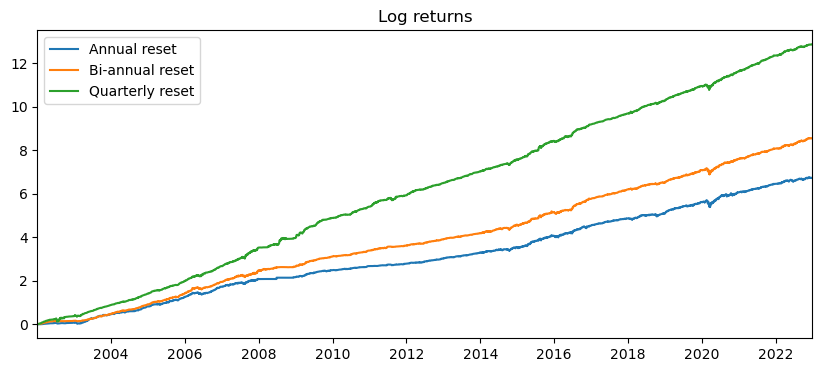

In [581]:
plt.figure(figsize=(10,4))
plt.title('Log returns')
plt.margins(x=0)
plt.plot(np.cumsum(annualReset), label='Annual reset')
plt.plot(np.cumsum(biAnnualReset), label='Bi-annual reset')
plt.plot(np.cumsum(quarterlyReset), label='Quarterly reset')
plt.grid()
plt.legend()
plt.savefig('media/Bannual_reset')
plt.show()

##### Out of sample

In [578]:
# Forward Annual
shiftedRet = portfolio.logReturns.shift(-(len(portfolio.logReturns[portfolio.logReturns.index.year==portfolio.logReturns.index.year[0]])))
FannualReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=0.0),index=portfolio.logReturns.index)
FannualReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.groupby(portfolio.logReturns.index.year):
    mean = x.mean()
    cov = x.cov()
    FannualReset['ret'][x.index]= shiftedRet.loc[x.index] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T
FannualReset = FannualReset.shift(len(portfolio.logReturns[portfolio.logReturns.index.year==portfolio.logReturns.index[0].year])).dropna()
# Forward FBiAnnual
shiftedRetBannual = portfolio.logReturns.shift(-int(len(portfolio.logReturns[portfolio.logReturns.index.year==portfolio.logReturns.index.year[0]])/2))
FBiAnnualReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=0.0),index=portfolio.logReturns.index)
FBiAnnualReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.resample('6M',label='right',closed='left'):
    meanReturns = x.mean()
    covMatrix = x.cov()
    FBiAnnualReset['ret'][x.index] = shiftedRetBannual.loc[x.index] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T
FBiAnnualReset = FBiAnnualReset.shift(int(len(portfolio.logReturns[portfolio.logReturns.index.year==portfolio.logReturns.index.year[0]])/2))
# Forward Quarterly
shiftedRetQuarterly = portfolio.logReturns.shift(-int(len(portfolio.logReturns[portfolio.logReturns.index.year==portfolio.logReturns.index.year[0]])/2))
FQuarterlyReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=0.0),index=portfolio.logReturns.index)
FQuarterlyReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.resample('Q',label='right',closed='left'):
    meanReturns = x.mean()
    covMatrix = x.cov()
    FQuarterlyReset['ret'][x.index] = shiftedRetQuarterly.loc[x.index] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T
FQuarterlyReset = FQuarterlyReset.shift(int(len(portfolio.logReturns[portfolio.logReturns.index.year==portfolio.logReturns.index.year[0]])/4))

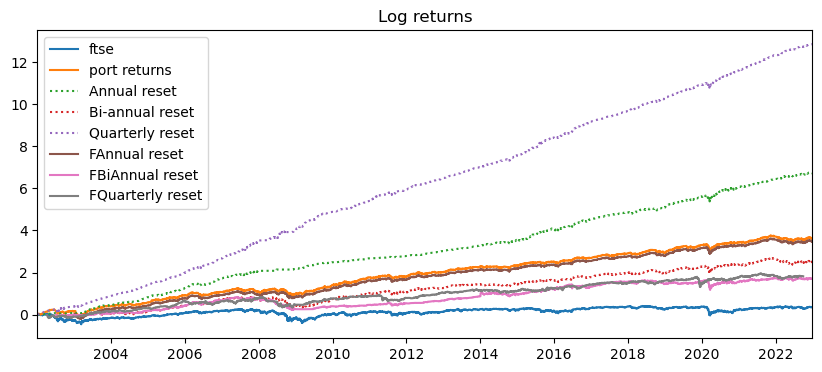

In [586]:
plt.figure(figsize=(10,4))
plt.title('Log returns')
plt.margins(x=0)
plt.plot(np.cumsum(ftseLogReturn), label='ftse')
plt.plot(np.cumsum(portfolio.portlogReturns), label='port returns')
plt.plot(np.cumsum(annualReset), label='Annual reset', ls=':')
plt.plot(np.cumsum(BannualReset), label='Bi-annual reset', ls=':')
plt.plot(np.cumsum(quarterlyReset), label='Quarterly reset', ls=':')
plt.plot(np.cumsum(FannualReset.dropna()), label='FAnnual reset')
plt.plot(np.cumsum(FBiAnnualReset.dropna()), label='FBiAnnual reset')
plt.plot(np.cumsum(FQuarterlyReset.dropna()), label='FQuarterly reset')
plt.grid()
plt.legend()
plt.show()

##### Cumulative sample

In [669]:
i,i+relativedelta(month=+6)

(Timestamp('2002-12-31 00:00:00', freq='6M'),
 Timestamp('2002-06-30 00:00:00', freq='6M'))

In [681]:
CBiAnnualReset.loc[CBiAnnualReset["Date"].between("2021-11-16", "2021-11-18")]

KeyError: 'Date'

In [657]:
# Cumulative annual
CannualReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=np.nan),index=portfolio.logReturns.index)
CannualReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.resample('1Y',label='right',closed='left'):
    meanReturns = portfolio.logReturns[:i].mean()
    covMatrix = portfolio.logReturns[:i].cov()
    CannualReset['ret'][i:i+relativedelta(years=1)]= portfolio.logReturns[i:i+relativedelta(years=1)] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T
# Cumulative Biannual
#CBiAnnualReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=np.nan),index=portfolio.logReturns.index)
#CBiAnnualReset.rename(columns={0:'ret'}, inplace=True)
#for i,x in portfolio.logReturns.resample('6m',label='right',closed='left'):
#    meanReturns = portfolio.logReturns[:i].mean()
#    covMatrix = portfolio.logReturns[:i].cov()
#    CBiAnnualReset['ret'].loc[i:i+relativedelta(month=+6)]= portfolio.logReturns.loc[i:i+relativedelta(month=+6)] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T
CBiAnnualReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=np.nan),index=portfolio.logReturns.index)
CBiAnnualReset.rename(columns={0:'ret'}, inplace=True)
for i,x in portfolio.logReturns.resample('6m',label='right',closed='left'):
    meanReturns = portfolio.logReturns[:i].mean()
    covMatrix = portfolio.logReturns[:i].cov()
    CBiAnnualReset['ret'][i:i+relativedelta(month=6)]= portfolio.logReturns[i:i+relativedelta(month=6)] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T


ValueError: cannot set using a slice indexer with a different length than the value

In [629]:
i, i+relativedelta(month=+6)

(Timestamp('2002-12-31 00:00:00', freq='6M'),
 Timestamp('2002-06-30 00:00:00', freq='6M'))

In [656]:
CannualReset = pd.DataFrame(np.full(len(portfolio.logReturns),fill_value=0.0),index=portfolio.logReturns.index)
CannualReset.rename(columns={0:'ret'}, inplace=True)
CBiAnnualReset['ret'].where[CBiAnnualReset.index>i]

TypeError: 'method' object is not subscriptable

In [645]:
i

Timestamp('2022-12-31 00:00:00', freq='6M')

In [646]:
for i,x in portfolio.logReturns.resample('6m',label='right',closed='left'):
    print(i)
    #print(CBiAnnualReset['ret'][i:i+relativedelta(months=+6)])

2002-06-30 00:00:00
2002-12-31 00:00:00
2003-06-30 00:00:00
2003-12-31 00:00:00
2004-06-30 00:00:00
2004-12-31 00:00:00
2005-06-30 00:00:00
2005-12-31 00:00:00
2006-06-30 00:00:00
2006-12-31 00:00:00
2007-06-30 00:00:00
2007-12-31 00:00:00
2008-06-30 00:00:00
2008-12-31 00:00:00
2009-06-30 00:00:00
2009-12-31 00:00:00
2010-06-30 00:00:00
2010-12-31 00:00:00
2011-06-30 00:00:00
2011-12-31 00:00:00
2012-06-30 00:00:00
2012-12-31 00:00:00
2013-06-30 00:00:00
2013-12-31 00:00:00
2014-06-30 00:00:00
2014-12-31 00:00:00
2015-06-30 00:00:00
2015-12-31 00:00:00
2016-06-30 00:00:00
2016-12-31 00:00:00
2017-06-30 00:00:00
2017-12-31 00:00:00
2018-06-30 00:00:00
2018-12-31 00:00:00
2019-06-30 00:00:00
2019-12-31 00:00:00
2020-06-30 00:00:00
2020-12-31 00:00:00
2021-06-30 00:00:00
2021-12-31 00:00:00
2022-06-30 00:00:00
2022-12-31 00:00:00


NameError: name 'CBiAnnualReset' is not defined

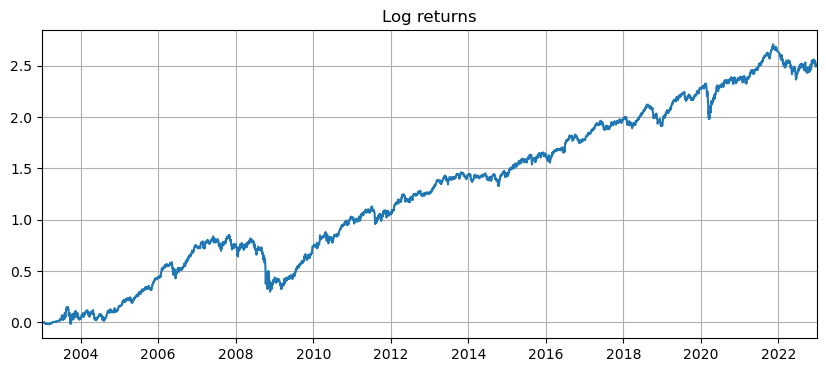

In [594]:
plt.figure(figsize=(10,4))
plt.title('Log returns')
plt.margins(x=0)
plt.plot(np.cumsum(CannualReset.dropna()), label='Cumulative Annual reset')
plt.plot(np.cumsum(CBiAnnualReset), label='Bi-annual reset')
#plt.plot(np.cumsum(quarterlyReset), label='Quarterly reset')
plt.grid()
plt.legend()
plt.show()

In [ ]:
for i in np.arange(0,len(port1.logReturns),228)[:-2]:
    meanReturns = port1.logReturns[:i+228].mean()
    covMatrix = port1.logReturns[:i+228].cov()
    BannualReset['ret'][i+228:i+456]= port1.logReturns[i+228:i+456] @ (pt.maxSharpeRatio(meanReturns,covMatrix)[1][1]).T

In [569]:
portfolio.logReturns.loc[:'2002-12-31']

ABF.L       ADM    ANTO.L       AON      AV.L     AVV.L  \
Date                                                                     
2002-01-03  0.016277 -0.010642 -0.004764  0.001969  0.007067  0.000000   
2002-01-04  0.003023 -0.037795  0.002861 -0.000281 -0.009434  0.016845   
2002-01-07 -0.005043 -0.005199  0.011364 -0.011596 -0.007135  0.022027   
2002-01-08  0.001010  0.022093  0.002821 -0.008572 -0.010195 -0.030975   
2002-01-09 -0.010152  0.002908  0.006551  0.002293 -0.017635 -0.022728   
2002-01-10 -0.007169  0.012270  0.000000  0.016187  0.010982 -0.008079   
2002-01-11 -0.010331 -0.002154  0.015734 -0.004800 -0.006086 -0.009313   
2002-01-14  0.006211  0.009303  0.004581 -0.009385 -0.022848 -0.035718   
2002-01-15  0.012308  0.019048  0.007286  0.032605  0.014264 -0.020354   
2002-01-16 -0.010302 -0.035565  0.000907 -0.032320  0.011632  0.030004   
2002-01-17 -0.005244 -0.013120 -0.000907  0.011925  0.013902 -0.001201   
2002-01-18 -0.011634 -0.011066 -0.001817 -0.011354 -0.003006 -0.002406   
2002-01-23  0.001045  0.005115 -0.001842 -0.022844 -0.006897  0.000000   
2002-01-24  0.000000 -0.005848 -0.007400 -0.008518  0.002879  0.022764   
2002-01-25 -0.005233 -0.011800 -0.003721 -0.000886 -0.014481  0.000000   
2002-01-28  0.000000  0.010332  0.001862 -0.007111 -0.002921  0.000000   
2002-01-29 -0.003153 -0.005891  0.000000 -0.019517 -0.007046 -0.020354   
2002-01-30  0.003153  0.003686  0.001859  0.001515 -0.023250 -0.006443   
2002-01-31 -0.001050  0.025428  0.025666  0.008141 -0.003625  0.009828   
2002-02-01  0.015634 -0.027638  0.004515 -0.002405 -0.007901  0.004877   
2002-02-04  0.009264 -0.011124 -0.001803 -0.012419 -0.012896  0.000000   
2002-02-05 -0.003078  0.000746  0.003604 -0.011958 -0.007444 -0.065350   
2002-02-06 -0.009293 -0.015072  0.007168 -0.010231 -0.013793  0.002594   
2002-02-07  0.000000  0.024007  0.000000  0.001557  0.020001  0.000000   
2002-02-08 -0.002077 -0.011931  0.004455  0.025522 -0.004962  0.000000   
2002-02-11  0.010341  0.020788  0.000000  0.010935  0.012361  0.003879   
2002-02-12 -0.006192 -0.000735  0.008849  0.027709  0.007344 -0.020358   
2002-02-13  0.032589  0.017493  0.008772  0.006445  0.000000 -0.035359   
2002-02-14 -0.010071  0.011494  0.069168  0.013053  0.012121 -0.004102   
2002-02-15  0.010071 -0.002862  0.000000  0.000000 -0.015787 -0.020345   
2002-02-20 -0.006129  0.016648 -0.002456  0.006320 -0.022202 -0.025846   
2002-02-21  0.011207 -0.020305  0.000000 -0.025229  0.009576  0.016211   
2002-02-22  0.003035  0.024603  0.000000  0.003225  0.000000 -0.020345   
2002-02-25  0.004033  0.000000 -0.001641  0.016548  0.003805  0.020345   
2002-02-26 -0.013165  0.005702  0.000000  0.004883  0.008822  0.000000   
2002-02-27  0.020182 -0.001423  0.000000  0.002290 -0.105779  0.002762   
2002-02-28  0.027588 -0.014337  0.004914 -0.010057  0.000697  0.000000   
2002-03-01  0.005814 -0.002892  0.000000  0.004610  0.011088 -0.002762   
2002-03-04 -0.011662  0.013664  0.000000  0.023015  0.008920  0.036664   
2002-03-05  0.000000  0.000000  0.010565 -0.017283  0.004770  0.017185   
2002-03-06  0.000977  0.028865  0.012053  0.002853  0.018188  0.000000   
2002-03-07  0.005842 -0.001388  0.007955 -0.024229 -0.004013  0.000000   
2002-03-08 -0.007797 -0.003481  0.000000  0.000292 -0.014855  0.015605   
2002-03-11 -0.008845  0.002090  0.002374  0.018509 -0.012320  0.000000   
2002-03-12  0.000987 -0.013310 -0.003167 -0.012688  0.015038  0.000000   
2002-03-13 -0.003953 -0.014920 -0.000793 -0.006405 -0.008175  0.000000   
2002-03-14 -0.004962  0.024047 -0.001589  0.007275 -0.002740  0.016635   
2002-03-15  0.021654  0.023482 -0.005580 -0.000580  0.030397  0.005064   
2002-03-18 -0.023646 -0.089186  0.000000  0.004342  0.030792  0.000000   
2002-03-19 -0.002996  0.028690  0.000000  0.008915  0.006431  0.000000   
2002-03-20  0.008960 -0.010937  0.000000 -0.004304 -0.023347 -0.019121   
2002-03-21 -0.001984  0.006576  0.000000  0.003445 -0.007244 -0.020355   
2002-03-22  0.00791

In [567]:
for i,x in portfolio.logReturns.resample('1Y',label='right',closed='left'):#
    print(i)
    #print(portfolio.logReturns.loc[:i])

2002-12-31 00:00:00
2003-12-31 00:00:00
2004-12-31 00:00:00
2005-12-31 00:00:00
2006-12-31 00:00:00
2007-12-31 00:00:00
2008-12-31 00:00:00
2009-12-31 00:00:00
2010-12-31 00:00:00
2011-12-31 00:00:00
2012-12-31 00:00:00
2013-12-31 00:00:00
2014-12-31 00:00:00
2015-12-31 00:00:00
2016-12-31 00:00:00
2017-12-31 00:00:00
2018-12-31 00:00:00
2019-12-31 00:00:00
2020-12-31 00:00:00
2021-12-31 00:00:00
2022-12-31 00:00:00


In [ ]:
portfolio.logReturns.loc[i]

In [ ]:
for i,x in portfolio.logReturns.resample('1Y',label='right',closed='left'):
    print(len(portfolio.logReturns.loc[i]))

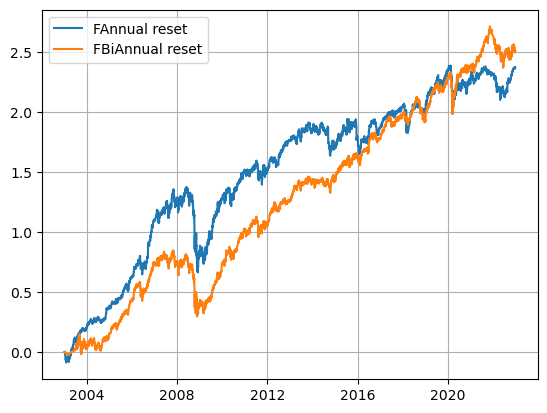

In [577]:
plt.plot(np.cumsum(FannualReset.dropna()), label='FAnnual reset')
plt.plot(np.cumsum(BannualReset.dropna()), label='FBiAnnual reset')
plt.legend()

In [533]:
pd.set_option('display.max_rows', None)
FBannualReset.isna().value_counts()

ret  
False    4855
True      121
dtype: int64